# Artificial Neural Network with MNIST Dataset
* Notebook coded by Adam Lang
* Date: 4/19/2024
* This was a code along as part of the course Deep Learning for Medical Image Analysis taught by Professor Jose Portilla from Udemy.
* We will build a simple neural network to predict and classify the images from the famous MNIST dataset and evaluate the results.
    * I will do this another way in another notebook comparing an alternative approach.
    * Then we will in another notebook show how a CNN network performs better on image data.
* More details about the MNIST dataset: https://en.wikipedia.org/wiki/MNIST_database
* The MNIST database (Modified National Institute of Standards and Technology database) is a large collection of handwritten digits. It has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger NIST Special Database 3 (digits written by employees of the United States Census Bureau) and Special Database 1 (digits written by high school students) which contain monochrome images of handwritten digits. The digits have been size-normalized and centered in a fixed-size image. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field. (source: https://paperswithcode.com/dataset/mnist)

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## datasets and dataloaders
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## standard imports
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Step 1 - Import MNIST Dataset

In [2]:
# MNIST IMAGE file => tensors
transform = transforms.ToTensor()

In [3]:
## load training set - setting root location of data - downloading data - dowload as tensor
train_data = datasets.MNIST(root='../Data',train=True,download=True,transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 143265223.91it/s]

Extracting ../Data/MNIST/raw/train-images-idx3-ubyte.gz to ../Data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 83599512.65it/s]


Extracting ../Data/MNIST/raw/train-labels-idx1-ubyte.gz to ../Data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 52825727.33it/s]

Extracting ../Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../Data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16310384.22it/s]


Extracting ../Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../Data/MNIST/raw



In [4]:
## loading test data
test_data = datasets.MNIST(root='../Data',train=False, download=True, transform=transform)

In [5]:
## look at train_data
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
## look at test_data
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

## 1.1 Image Exploratory Data Analysis (EDA)

In [7]:
## check types
type(train_data)

torchvision.datasets.mnist.MNIST

What we see below:
* MNIST data was uploaded and transformed into tensors.
* We can see the image label at the bottom as `5`

In [8]:
## index train_data
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

We can see this is actually a tuple!

In [9]:
## check type
type(train_data[0])

tuple

## Let's unpack the tuple

In [10]:
image, label = train_data[0]

In [11]:
image.shape

torch.Size([1, 28, 28])

summary:
* `1` - gray scale image - single color channel (black/white)
* 28 height
* 28 width

In [12]:
## check label
label

5

# Step 2: Data Visualization
* Note:
  * We need to drop the color channel (1) noting its a gray scale image by reshaping the tensor in order to visualize.
  * The default color will be `Viridis`, therefore if this is gray scale we need to provide a color mapping to offset the default.

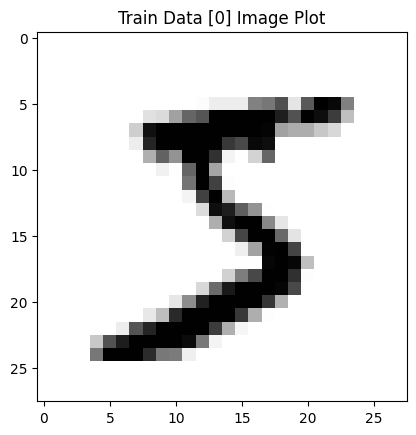

In [13]:
## visualize - reshape tensor by dropping the color channel (1)
plt.imshow(image.reshape((28,28)),cmap='gist_yarg') # can use `gray' or `gist_yarg' to invert
plt.title("Train Data [0] Image Plot");

# Step 3 - Build DataLoaders
* We will need to set up batches because your dataset is so large.

In [14]:
## set manual seed
torch.manual_seed(101)

## train dataloader
## set up `shuffle` so NN does not memorize data order
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

## test dataloader
## No shuffling of the test data since it is the validation set
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [15]:
## make a grid
from torchvision.utils import make_grid
# function to format the grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

In [16]:
# FIRST BATCH of images
for images, labels in train_loader:
  # 60,000 / 100 = 60 times loop runs
  # we only want FIRST BATCH
  break

In [17]:
images

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [18]:
# shape
images.shape

torch.Size([100, 1, 28, 28])

Summary:
* We just printed a 1D tensor which is the FIRST BATCH of data.
* 100 images
* 1 color channel (grayscale)
* size= 28x28

In [19]:
## labels shape
labels.shape

torch.Size([100])

### 3.1 Look at labels for dataset

In [20]:
# print first 12 labels
print('Labels: ', labels[:12].numpy())

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


Note:
* We are going to need to transpose the images from CWH (color width height) to WHC (width height color)
* Matplotlib and imshow need the WHC format

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


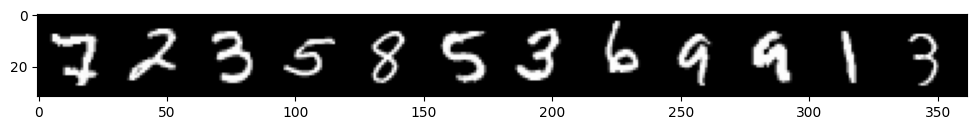

In [21]:
# print first 12 labels
print('Labels: ', labels[:12].numpy())
# print first 12 images
im = make_grid(images[:12], nrow=12) # default nrow is 8
plt.figure(figsize=(12,4))
# we need to transpose images from CWH (color, width, height) to WHC (width, height, color)
plt.imshow(np.transpose(im.numpy(), (1,2,0)));

Summary:
* We can see some of the image data is not pristine and the neural network may improperly label the data.

# Step 4 - Build Perceptron model

In [22]:
class MultilayerPerceptron(nn.Module):

  def __init__(self,in_sz=784,out_sz=10,layers=[120,84]):
    # instantiate nn module
    super().__init__()
    # fully connected layer 1 = fc1
    self.fc1 = nn.Linear(in_sz,layers[0])
    self.fc2 = nn.Linear(layers[0],layers[1])
    self.fc3 = nn.Linear(layers[1], out_sz)

  #forward method
  def forward(self,X):

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X) #no ReLU

    return F.log_softmax(X,dim=1) #MULTI-CLASS CLASSIFICATION

In [23]:
## SET SEED
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

#### Print out all model parameters

In [24]:
# ANN ----> CNN
for param in model.parameters():
  print(param.numel())

94080
120
10080
84
840
10


Summary:
* We can see these parameters above that if we were to sum them up we would get a total of 105,214 parameters!
* This is why we will move to a more efficient CNN or Convolutional Neural Network later on as it is not only more efficient but handles image data better with less parameters.

### Define loss function + optimizer

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

### How are we going to flatten out the training data?
* Recall that the shape of the images is right now is 100 x 1 x 28 x 28, we need to flatten this to be able to process in a neural network.
* We want to multiply the last 3 dimensions (1x28x28)

In [26]:
## recall shape
images.shape  ## need to convert ---->[100,784]

torch.Size([100, 1, 28, 28])

What is the quickest way to do this? Use `view`

In [27]:
images.view(100,-1)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [28]:
## check shape of above
images.view(100,-1).shape

torch.Size([100, 784])

Summary:
* We can see we just compressed this from 1x4 to 1x2.
* Note, view is similar to `reshape` in numpy. It is not the same as squeeze or unsqueeze.

# Step 5 - Training the model

In [38]:
## import time

##starting timer for training duration
import time
start_time = time.time()


# TRAINING
epochs = 20 # this is up to you

# TRACKERS - these are optional
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# ACTUAL TRAINING
for i in range(epochs):

  trn_corr = 0
  tst_corr = 0

  for b, (X_train, y_train) in enumerate(train_loader):

      b+=1
      # predictions and flatten out the data with view()
      # last layer has 10 neurons [0.1, 0.0,......0.8] -> 9
      y_pred = model(X_train.view(100,-1))
      loss = criterion(y_pred, y_train)

      #optional calculation
      # this indexes the max value of the prediction probabilities
      #batch_corr is "batch correct"
      predicted = torch.max(y_pred.data,1)[1]
      batch_corr = (predicted == y_train).sum() ## how many matches do we have that are equal to the predicted val
      trn_corr += batch_corr

      # Calculate losses
      #train_loss = calculate_train_loss()
      #test_loss = calculate_test_loss()




      # update parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # print results during training
      if b%200 == 0:
        acc = trn_corr.item()*100/(100*b)
        print(f'Epoch {i} | batch{b} | loss:{loss.item()} | accuracy:{acc}')


  # updated losses
  train_losses.append(loss.item())
  train_correct.append(trn_corr.item())


  #testing loop
  with torch.no_grad():

      for b, (X_test, y_test) in enumerate(test_loader):

          y_val = model(X_test.view(500,-1))

          predicted = torch.max(y_val.data,1)[-1]
          tst_corr += (predicted==y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

total_time = time.time() - start_time
print(f'Duration: {total_time/60} mins')

Epoch 0 | batch200 | loss:0.000643752864561975 | accuracy:99.88
Epoch 0 | batch400 | loss:0.00011634788825176656 | accuracy:99.93
Epoch 0 | batch600 | loss:0.04884080961346626 | accuracy:99.925
Epoch 1 | batch200 | loss:0.00017996931273955852 | accuracy:99.935
Epoch 1 | batch400 | loss:0.0005591813824139535 | accuracy:99.8825
Epoch 1 | batch600 | loss:0.00031807099003344774 | accuracy:99.84833333333333
Epoch 2 | batch200 | loss:0.000752305961214006 | accuracy:99.94
Epoch 2 | batch400 | loss:0.0001837748714024201 | accuracy:99.945
Epoch 2 | batch600 | loss:5.282960046315566e-05 | accuracy:99.90333333333334
Epoch 3 | batch200 | loss:0.013393406756222248 | accuracy:99.8
Epoch 3 | batch400 | loss:0.003878046525642276 | accuracy:99.805
Epoch 3 | batch600 | loss:0.0074710785411298275 | accuracy:99.8
Epoch 4 | batch200 | loss:0.003559167729690671 | accuracy:99.895
Epoch 4 | batch400 | loss:0.0014224870828911662 | accuracy:99.86
Epoch 4 | batch600 | loss:0.0013170614838600159 | accuracy:99.818

# Step 6 - Evaluation

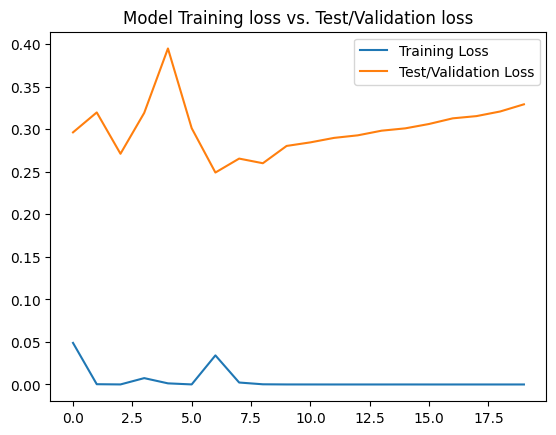

In [40]:
## begin by plotting losses vs. accuracy for train vs. test
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test/Validation Loss')
plt.legend()
plt.title("Model Training loss vs. Test/Validation loss");
plt.show();

Summary:
* The training loss remained low throughout.
* The test loss was rather high and with more epochs kept getting higher. This means the model is **underfitting** the data and the model itself may not be complex enough to learn the patterns in the dataset.
* The test set does not get to adjust its weights and biases.

In [44]:
train_acc = [t/600 for t in train_correct]
train_acc

[99.925,
 99.84833333333333,
 99.90333333333334,
 99.8,
 99.81833333333333,
 99.87833333333333,
 99.83833333333334,
 99.94333333333333,
 99.995,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0]

In [45]:
test_acc = [t/100 for t in test_correct] #100 is batch size
test_acc

[tensor(97.8400),
 tensor(97.7700),
 tensor(97.6000),
 tensor(97.9700),
 tensor(97.6600),
 tensor(98.0400),
 tensor(97.7800),
 tensor(97.9700),
 tensor(98.0800),
 tensor(98.1700),
 tensor(98.1400),
 tensor(98.1400),
 tensor(98.1100),
 tensor(98.1100),
 tensor(98.1600),
 tensor(98.1500),
 tensor(98.1700),
 tensor(98.1700),
 tensor(98.1800),
 tensor(98.1600)]

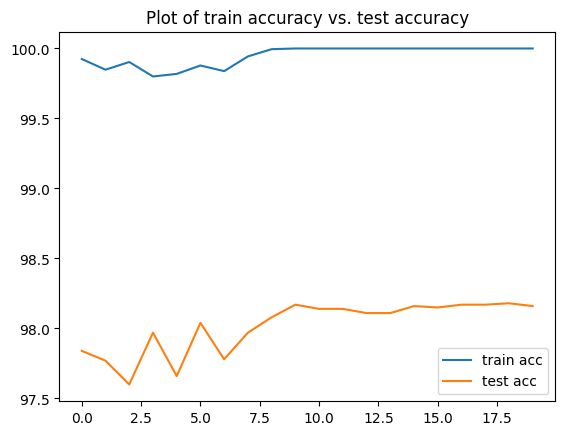

In [46]:
# plot these accuracies over time
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label = 'test acc')
plt.legend()
plt.title("Plot of train accuracy vs. test accuracy");

Summary:
* Train accuracy was perfect
* Test accuracy was not, this is because the test set can not adjust its weights and biases.
* We can see after about 8 epochs the model levels off for both train and test.

## How can I run new unseen image data through my new image neural network model?

In [47]:
# new unseen data

test_load_all = DataLoader(test_data, batch_size=10000,shuffle=False)

In [48]:
## eval new unseen images
with torch.no_grad():
  correct = 0

  for X_test, y_test in test_load_all:
      y_val = model(X_test.view(len(X_test),-1))
      predicted = torch.max(y_val,1)[1]
      correct += (predicted==y_test).sum()

In [50]:
# look at correct
100*correct.item()/len(test_data)

98.16

Acc = 98.16% on test set

### Confusion Matrix

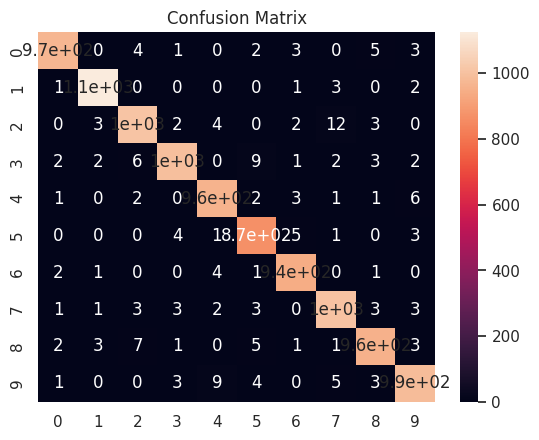

In [62]:
conf_mat = confusion_matrix(predicted.view(-1),y_test.view(-1))
import seaborn as sns
## heatmap of confusion matrix
sns.heatmap(conf_mat,annot=True).set(title="Confusion Matrix")
sns.set(font_scale=-2.0)

In [54]:
conf_mat

array([[ 970,    0,    4,    1,    0,    2,    3,    0,    5,    3],
       [   1, 1125,    0,    0,    0,    0,    1,    3,    0,    2],
       [   0,    3, 1010,    2,    4,    0,    2,   12,    3,    0],
       [   2,    2,    6,  996,    0,    9,    1,    2,    3,    2],
       [   1,    0,    2,    0,  962,    2,    3,    1,    1,    6],
       [   0,    0,    0,    4,    1,  866,    5,    1,    0,    3],
       [   2,    1,    0,    0,    4,    1,  942,    0,    1,    0],
       [   1,    1,    3,    3,    2,    3,    0, 1003,    3,    3],
       [   2,    3,    7,    1,    0,    5,    1,    1,  955,    3],
       [   1,    0,    0,    3,    9,    4,    0,    5,    3,  987]])

# Examine missed predictions

In [63]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')

# Display the number of misses
len(misses)

184

In [64]:
# Display the first 10 index positions
misses[:10]

array([ 149,  151,  247,  321,  340,  445,  495,  582,  684,  720])

In [65]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [ 149  151  247  321  340  445  495  582  684  720  882  900]
Label: [   2    9    4    2    5    6    8    8    7    5    9    1]
Guess: [   3    8    2    7    3    0    2    2    3    8    7    3]


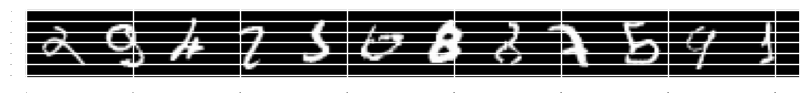

In [66]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# Conclusions
* We trained an artificial neural network to classify and predict image labels for the famous MNIST dataset.
* We can see that the network performance despite the metrics showing 100% accuracy the loss on the test set was poor and underfit the data.
    * Examples of underfitting: https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
* We can see there were about 184 missed labels.
* In forthcoming notebooks we will look at more efficient ways to build a neural net to predict and classify this data.
* We will also look at ways to finetune the results and prevent underfitting such as:
    * Changing learning rate
    * Change loss function and/or optimizer
    * Tune hyperparameters and layers such as adding dropout.